In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("LeagueofLegends.csv")

In [3]:
print(df)

     League  Year  Season    Type blueTeamTag  bResult  rResult redTeamTag  \
0     NALCS  2015  Spring  Season         TSM        1        0         C9   
1     NALCS  2015  Spring  Season         CST        0        1        DIG   
2     NALCS  2015  Spring  Season         WFX        1        0         GV   
3     NALCS  2015  Spring  Season         TIP        0        1         TL   
4     NALCS  2015  Spring  Season         CLG        1        0         T8   
...     ...   ...     ...     ...         ...      ...      ...        ...   
7615    TCL  2018  Spring  Season          YC        0        1        SUP   
7616    TCL  2018  Spring  Season         GAL        0        1         DP   
7617    OPL  2018  Spring  Season         SIN        0        1         DW   
7618    OPL  2018  Spring  Season         LGC        1        0        TTC   
7619    OPL  2018  Spring  Season         TTC        0        1        LGC   

      gamelength                                           gold

In [4]:
df.drop(['League', 'Season', 'Type', 'blueTeamTag', 'goldblueTop', 'goldblueJungle', 'goldblueMiddle', 
         'goldblueADC', 'goldblueSupport', 'redTop', 'goldredTop', 'redJungle', 'goldredJungle', 
         'redMiddle', 'goldredMiddle', 'redADC', 'goldredADC', 'redSupport', 'goldredSupport', 'redTeamTag', 
         'blueTop', 'blueMiddle', 'blueJungle', 'blueADC', 'blueSupport'], axis=1, inplace=True)

In [5]:
df.columns

Index(['Year', 'bResult', 'rResult', 'gamelength', 'golddiff', 'goldblue',
       'bKills', 'bTowers', 'bInhibs', 'bDragons', 'bBarons', 'bHeralds',
       'goldred', 'rKills', 'rTowers', 'rInhibs', 'rDragons', 'rBarons',
       'rHeralds', 'blueTopChamp', 'blueJungleChamp', 'blueMiddleChamp',
       'blueADCChamp', 'blueSupportChamp', 'blueBans', 'redTopChamp',
       'redJungleChamp', 'redMiddleChamp', 'redADCChamp', 'redSupportChamp',
       'redBans', 'Address'],
      dtype='object')

In [6]:
df.isnull().sum()

Year                0
bResult             0
rResult             0
gamelength          0
golddiff            0
goldblue            0
bKills              0
bTowers             0
bInhibs             0
bDragons            0
bBarons             0
bHeralds            0
goldred             0
rKills              0
rTowers             0
rInhibs             0
rDragons            0
rBarons             0
rHeralds            0
blueTopChamp        0
blueJungleChamp     0
blueMiddleChamp     0
blueADCChamp        0
blueSupportChamp    0
blueBans            0
redTopChamp         0
redJungleChamp      0
redMiddleChamp      0
redADCChamp         0
redSupportChamp     0
redBans             0
Address             0
dtype: int64

<AxesSubplot:title={'center':'gamelength'}, ylabel='Frequency'>

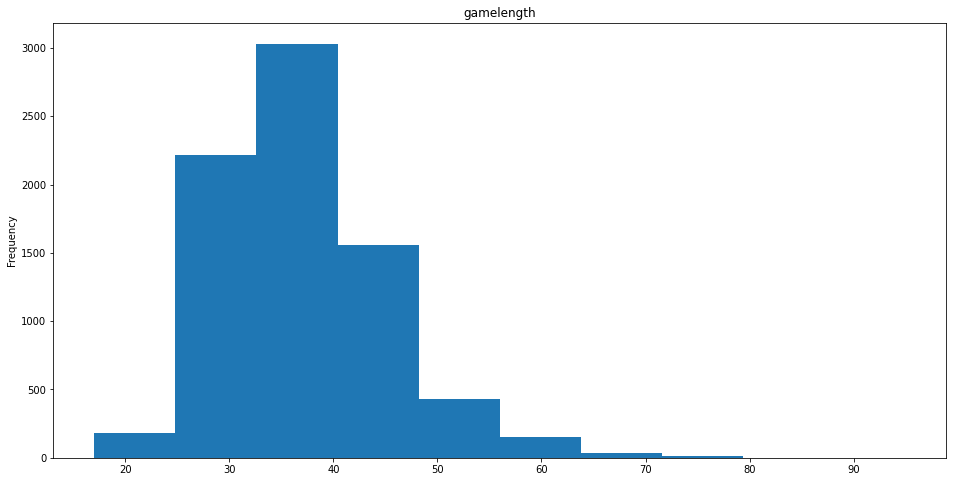

In [7]:
plt.figure('gamelength', figsize=(16,8))
plt.title('gamelength')
df['gamelength'].plot(kind='hist')

In [8]:
df.describe()['gamelength']

count    7620.000000
mean       37.012598
std         7.983238
min        17.000000
25%        31.000000
50%        36.000000
75%        41.000000
max        95.000000
Name: gamelength, dtype: float64

In [9]:
def find_outliers(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    IQR = q3-q1
    outliers = df[((df[col] < (q1 - 1.5*IQR)) | (df[col] > (q3 + 1.5*IQR)))]
    return outliers

In [10]:
outliers = find_outliers(df, 'gamelength').index
print(outliers)

Int64Index([ 165,  175,  181,  243,  248,  298,  314,  318,  338,  345,
            ...
            7240, 7261, 7297, 7430, 7438, 7439, 7447, 7515, 7551, 7570],
           dtype='int64', length=164)


In [11]:
df = df.drop(outliers)

In [12]:
print(df)

      Year  bResult  rResult  gamelength  \
0     2015        1        0          40   
1     2015        0        1          38   
2     2015        1        0          40   
3     2015        0        1          41   
4     2015        1        0          35   
...    ...      ...      ...         ...   
7615  2018        0        1          34   
7616  2018        0        1          39   
7617  2018        0        1          24   
7618  2018        1        0          35   
7619  2018        0        1          42   

                                               golddiff  \
0     [0, 0, -14, -65, -268, -431, -488, -789, -494,...   
1     [0, 0, -26, -18, 147, 237, -152, 18, 88, -242,...   
2     [0, 0, 10, -60, 34, 37, 589, 1064, 1258, 913, ...   
3     [0, 0, -15, 25, 228, -6, -243, 175, -346, 16, ...   
4     [40, 40, 44, -36, 113, 158, -121, -191, 23, 20...   
...                                                 ...   
7615  [0, 0, -18, -95, 45, -87, -117, 199, 126, 92, ...   

In [13]:
df.describe()

,Year,bResult,rResult,gamelength
count,7456.000000,7456.000000,7456.000000,7456.000000
mean,2016.282591,0.543723,0.456277,36.458423
std,0.847736,0.498118,0.498118,7.078681
min,2014.000000,0.000000,0.000000,17.000000
25%,2016.000000,0.000000,0.000000,31.000000
50%,2016.000000,1.000000,0.000000,36.000000
75%,2017.000000,1.000000,1.000000,41.000000
max,2018.000000,1.000000,1.000000,56.000000


In [14]:
killdf = pd.read_csv("kills.csv")

In [15]:
kills = killdf.groupby(["Address", "Team"]).size().reset_index(name = "Kills")

In [16]:
kills

,Address,Team,Kills
0,http://matchhistory.br.leagueoflegends.com/pt/...,bKills,6
1,http://matchhistory.br.leagueoflegends.com/pt/...,rKills,1
2,http://matchhistory.br.leagueoflegends.com/pt/...,bKills,22
3,http://matchhistory.br.leagueoflegends.com/pt/...,rKills,19
4,http://matchhistory.br.leagueoflegends.com/pt/...,bKills,11
...,...,...,...
15235,https://matchhistory.na.leagueoflegends.com/en...,rKills,1
15236,https://matchhistory.na.leagueoflegends.com/en...,bKills,2
15237,https://matchhistory.na.leagueoflegends.com/en...,rKills,14
15238,https://matchhistory.na.leagueoflegends.com/en...,bKills,11


In [17]:
bKills = kills[kills['Team'] == 'bKills']
rKills = kills[kills['Team'] == 'rKills']

In [18]:
print(df.loc[(df['Address'] == 'http://matchhistory.na.leagueoflegends.com/en/#match-details/TRLH1/30030?gameHash=fbb300951ad8327c'), 'bKills'])

0    [[10.82, 'C9 Hai', 'TSM Bjergsen', [], 9229, 8...
Name: bKills, dtype: object


In [19]:
for row in bKills.index:
    addr = bKills.loc[row, 'Address']
    df.loc[(df['Address'] == addr), 'bKills'] = bKills.loc[row, 'Kills']

In [20]:
print(df[['Address', 'bKills']])

                                                Address bKills
0     http://matchhistory.na.leagueoflegends.com/en/...     16
1     http://matchhistory.na.leagueoflegends.com/en/...     10
2     http://matchhistory.na.leagueoflegends.com/en/...     22
3     http://matchhistory.na.leagueoflegends.com/en/...     10
4     http://matchhistory.na.leagueoflegends.com/en/...     22
...                                                 ...    ...
7615  https://matchhistory.euw.leagueoflegends.com/e...      7
7616  https://matchhistory.euw.leagueoflegends.com/e...      8
7617  https://matchhistory.na.leagueoflegends.com/en...      5
7618  https://matchhistory.na.leagueoflegends.com/en...     16
7619  https://matchhistory.na.leagueoflegends.com/en...     12

[7456 rows x 2 columns]


In [21]:
for row in rKills.index:
    addr = rKills.loc[row, 'Address']
    df.loc[(df['Address'] == addr), 'rKills'] = rKills.loc[row, 'Kills']

In [22]:
print(df[['Address', 'bKills', 'rKills']])

                                                Address bKills rKills
0     http://matchhistory.na.leagueoflegends.com/en/...     16      9
1     http://matchhistory.na.leagueoflegends.com/en/...     10      9
2     http://matchhistory.na.leagueoflegends.com/en/...     22      8
3     http://matchhistory.na.leagueoflegends.com/en/...     10     21
4     http://matchhistory.na.leagueoflegends.com/en/...     22     10
...                                                 ...    ...    ...
7615  https://matchhistory.euw.leagueoflegends.com/e...      7     16
7616  https://matchhistory.euw.leagueoflegends.com/e...      8     18
7617  https://matchhistory.na.leagueoflegends.com/en...      5     13
7618  https://matchhistory.na.leagueoflegends.com/en...     16      2
7619  https://matchhistory.na.leagueoflegends.com/en...     12     23

[7456 rows x 3 columns]
